# Assignment 5
## Anselmo Raffaele
Matricola: 846842  
Mail: r.anselmo@campus.unimib.it

## Installing SMAC

In [1]:
#Installing SMAC
!apt-get install swig
!pip install smac[all]  

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following packages were automatically installed and are no longer required:
  cuda-cufft-10-1 cuda-cufft-dev-10-1 cuda-curand-10-1 cuda-curand-dev-10-1
  cuda-cusolver-10-1 cuda-cusolver-dev-10-1 cuda-cusparse-10-1
  cuda-cusparse-dev-10-1 cuda-license-10-2 cuda-npp-10-1 cuda-npp-dev-10-1
  cuda-nsight-10-1 cuda-nsight-compute-10-1 cuda-nsight-systems-10-1
  cuda-nvgraph-10-1 cuda-nvgraph-dev-10-1 cuda-nvjpeg-10-1
  cuda-nvjpeg-dev-10-1 cuda-nvrtc-10-1 cuda-nvrtc-dev-10-1 cuda-nvvp-10-1
  libcublas10 libnvidia-common-430 nsight-compute-2019.5.0
  nsight-systems-2019.5.2
Use 'apt autoremove' to remove them.
The following additional packages will be installed:
  swig3.0
Suggested packages:
  swig-doc swig-examples swig3.0-examples swig3.0-doc
The following NEW packages will be installed:
  swig swig3.0
0 upgraded, 2 newly installed, 0 to remove and 5 not upgraded.
Need to get 1,100 kB of a

## Import Libraries

In [0]:
from smac.facade.func_facade import fmin_smac
from smac.facade.smac_hpo_facade import SMAC4HPO #Bayesian optimization using a Random Forest

# Import ConfigSpace and different types of parameters
from smac.configspace import ConfigurationSpace
from ConfigSpace.hyperparameters import CategoricalHyperparameter, \
    UniformFloatHyperparameter, UniformIntegerHyperparameter
from ConfigSpace.conditions import InCondition
from smac.configspace.util import convert_configurations_to_array

# Import SMAC-utilities
from smac.tae.execute_func import ExecuteTAFuncDict
from smac.scenario.scenario import Scenario
from smac.optimizer.acquisition import EI, LCB
from smac.initial_design.initial_design import InitialDesign
from smac.initial_design.random_configuration_design import RandomConfigurations

In [0]:
import numpy as np
import pandas as pd

In [4]:
# Import utilities
import logging
logging.basicConfig(level=logging.INFO)
logging.captureWarnings(capture=True)
logger = logging.getLogger("py.warnings")
handler = logging.StreamHandler()
logger.addHandler(handler)
logger.addFilter(lambda record: "ConvergenceWarning" not in record.getMessage())
from collections import Counter

import matplotlib.pyplot as plt

from scipy.stats import uniform

# Import sklearn libraries 
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline, make_pipeline
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, cross_val_score, cross_val_predict
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)

  "(https://pypi.org/project/six/).", DeprecationWarning)



In [0]:
seed = np.random.RandomState(42)

## Import dataset

In [0]:
df = pd.read_csv("https://www.openml.org/data/get_csv/1587930/php9pgo5r")
data = np.asarray(df)

In [0]:
y = data[:,9]
y[y==2] = 0 #convert y values to 1-0

In [0]:
x = data[:,0:8]

In [9]:
Counter(y)

Counter({0.0: 12, 1.0: 88})

# STEP 1

In [0]:
# defining results dictionary that will be populated when experiments run
res_1 = {}

In [0]:
# Hyperparameters range
lr_lower = 0.01
lr_upper = 0.1
momentum_lower = 0.1
momentum_upper = 0.9

### Configuration Space and Scenario definition

In [0]:
# defining learning rate optimization range
learn_rate = UniformFloatHyperparameter("learning_rate_init", 
                                        lower=lr_lower, 
                                        upper=lr_upper)

In [0]:
# defining momentum rate optimization range
momentum = UniformFloatHyperparameter("momentum", 
                                      lower=momentum_lower, 
                                      upper=momentum_upper)

In [0]:
# Build Configuration Space which defines all parameters and their ranges
cs = ConfigurationSpace()

In [15]:
cs.add_hyperparameters([learn_rate, momentum])

[learning_rate_init, Type: UniformFloat, Range: [0.01, 0.1], Default: 0.055,
 momentum, Type: UniformFloat, Range: [0.1, 0.9], Default: 0.5]

In [0]:
initial_runs = 5
further_runs = 20

In [0]:
# defining 5 random initial configurations (the same for the different experiments)
initial_configs = cs.sample_configuration(size = initial_runs)

In [18]:
# defining Scenario to maximize accuracy
scenario = Scenario({"run_obj": "quality",
                     "runcount-limit":initial_runs + further_runs,
                     "cs":cs,
                     "deterministic":"true"
                     })

INFO:smac.utils.io.cmd_reader.CMDReader:Output to smac3-output_2019-12-09_10:49:16_494292


## Hyperparameter Optimization

### Evaluation Functions

In [0]:
# plot the evolution of "best seen" 
def plot_bestseen(dic, runs):
  x_ax = np.arange(runs)
  plt.figure(figsize=(15, 8))
  ax = plt.subplot(111)
  for alg in dic:
    ax.plot(x_ax, dic[alg]['bestseen'], label=alg)
  ax.legend(loc='upper center', 
            bbox_to_anchor=(0.5, -0.05), 
            shadow=True, 
            ncol=2)
  plt.title('Best Seen')
  plt.show()

In [0]:
#Make predictions and return the classification report
def CR(incumbent_cfg):
  smote = SMOTE(random_state=seed)
  mlp = MLPClassifier(hidden_layer_sizes=(4, 2,),
                      random_state=seed,
                      **incumbent_cfg)
  
  model_pipeline = make_pipeline(smote, StandardScaler(), mlp)
  predictions = cross_val_predict(model_pipeline, x,y, cv =10)
  CR = classification_report(y, predictions)
  print(CR)

### Smac Optimization functions

In [0]:
# Function to be optimized
def nn_from_cfg(cfg):
  smote = SMOTE(random_state=seed)
  mlp = MLPClassifier(hidden_layer_sizes=(4, 2,),
                      random_state=seed,
                      **cfg)
  model_pipeline = make_pipeline(smote, StandardScaler(), mlp)
  scores = cross_val_score(model_pipeline, x, y, cv=10)
  return 1-np.mean(scores)  # Minimize 1-accuracy (maximize accuracy!)

In [0]:
# Function that run and optimize smac
def run_smac(acquisition_function):
    smac = SMAC4HPO(scenario=scenario, 
                   rng=seed,
                   tae_runner=nn_from_cfg,
                   initial_design_kwargs={'configs': initial_configs},
                   acquisition_function=acquisition_function
                   )

    incumbent = smac.optimize()
    bestseen = 1-np.minimum.accumulate(list(
        smac.get_runhistory().cost_per_config.values()
        ))
    # put best configuration and bestseen in results dictionary
    res_1[f"HPO - {acquisition_function.__name__}"] = {
    'best_config': list(incumbent._values.values()),
    'bestseen': bestseen
    }
    return incumbent

### Experiment 1: Expect Input as acquisition function

In [23]:
# run HPO with Expected Input as acquisition function
HPO_EI = run_smac(acquisition_function=EI)

INFO:smac.facade.smac_hpo_facade.SMAC4HPO:Optimizing a deterministic scenario for quality without a tuner timeout - will make SMAC deterministic and only evaluate one configuration per iteration!
INFO:smac.initial_design.sobol_design.SobolDesign:Running initial design for 6 configurations
INFO:smac.facade.smac_hpo_facade.SMAC4HPO:<class 'smac.facade.smac_hpo_facade.SMAC4HPO'>
INFO:smac.intensification.intensification.Intensifier:Challenger (0.3603) is better than incumbent (0.3865) on 1 runs.
INFO:smac.intensification.intensification.Intensifier:Changes in incumbent:
INFO:smac.intensification.intensification.Intensifier:  learning_rate_init : 0.02228266487193023 -> 0.09517008174756114
INFO:smac.intensification.intensification.Intensifier:  momentum : 0.4970542653449348 -> 0.21629677511966286
INFO:smac.intensification.intensification.Intensifier:Challenger (0.2999) is better than incumbent (0.3603) on 1 runs.
INFO:smac.intensification.intensification.Intensifier:Changes in incumbent:
IN

### Experiment 2: Lower Confidence Bound as acquisition function

In [24]:
# run HPO with LowerConfidenceBound as acquisition function
HPO_LCB = run_smac(acquisition_function=LCB)

INFO:smac.facade.smac_hpo_facade.SMAC4HPO:Optimizing a deterministic scenario for quality without a tuner timeout - will make SMAC deterministic and only evaluate one configuration per iteration!
INFO:smac.initial_design.sobol_design.SobolDesign:Running initial design for 6 configurations
INFO:smac.facade.smac_hpo_facade.SMAC4HPO:<class 'smac.facade.smac_hpo_facade.SMAC4HPO'>
INFO:smac.intensification.intensification.Intensifier:Challenger (0.2533) is better than incumbent (0.2956) on 1 runs.
INFO:smac.intensification.intensification.Intensifier:Changes in incumbent:
INFO:smac.intensification.intensification.Intensifier:  learning_rate_init : 0.02228266487193023 -> 0.027566985550730408
INFO:smac.intensification.intensification.Intensifier:  momentum : 0.4970542653449348 -> 0.517048341649604
INFO:smac.intensification.intensification.Intensifier:Challenger (0.2310) is better than incumbent (0.2533) on 1 runs.
INFO:smac.intensification.intensification.Intensifier:Changes in incumbent:
INF

## Grid Search vs Random Search

In [0]:
#Classifier RS and GS
smote = SMOTE(random_state=seed)

mlp = MLPClassifier(hidden_layer_sizes=(4,2,),
                    random_state=seed
                    )

model_pipeline = Pipeline([('smote', smote),
                           ('scaler',StandardScaler()), 
                           ('mlp', mlp)],
                          verbose=True)

### Grid Search

In [0]:
lr_range = np.linspace(lr_lower, lr_upper, 5)
momentum_range = np.linspace(momentum_lower, momentum_upper, 5)

grid_params = {'mlp__learning_rate_init': lr_range,
               'mlp__momentum': momentum_range}

n_folds = 10  #10 folds CV

In [0]:
grid_search = GridSearchCV(estimator=model_pipeline,
                  param_grid=grid_params,
                  cv=10,
                  verbose=1)

In [28]:
grid_search_result = grid_search.fit(x, y) 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 10 folds for each of 25 candidates, totalling 250 fits


[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:   15.3s finished
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)

  DeprecationWarning)



In [0]:
prog_gs = grid_search_result.cv_results_['mean_test_score']
best_gs = list(grid_search_result.best_params_.values())
bestseen_gs = np.maximum.accumulate(prog_gs)

res_1['GRID SEARCH'] = {
    'best_config': best_gs,
    'bestseen': bestseen_gs
}

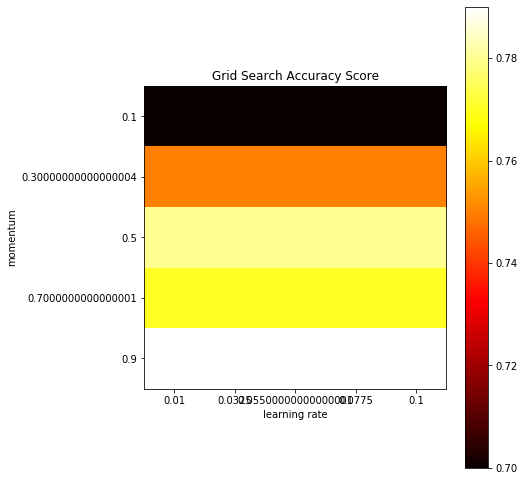

In [30]:
# Grid Seach Heat Map
prog_gs = prog_gs.reshape(len(lr_range),len(momentum_range))
plot_gs = plt.figure(figsize=(7, 8))
plt.subplots_adjust(left=.2, right=0.95, bottom=0.15, top=0.95)
plt.imshow(prog_gs, interpolation='nearest', cmap=plt.cm.hot)
plt.xlabel('learning rate')
plt.ylabel('momentum')
plt.colorbar()
plt.xticks(np.arange(len(lr_range)), lr_range)
plt.yticks(np.arange(len(momentum_range)), momentum_range)
plt.title('Grid Search Accuracy Score')
plt.show()


### Random Search

In [0]:
lr_dist = uniform(lr_lower, lr_upper - lr_lower)
lr_dist.random_state = seed

mom_dist = uniform(momentum_lower, momentum_upper - momentum_lower)
mom_dist.random_state = seed

random_params = {
    'mlp__learning_rate_init': lr_dist,
    'mlp__momentum': mom_dist
    }

In [0]:
random_search = RandomizedSearchCV(estimator=model_pipeline,
                              param_distributions=random_params,
                              n_iter=25,
                              cv=10,
                              verbose=1,
                              random_state=seed)

In [33]:
random_search_result = random_search.fit(x, y) 

Fitting 10 folds for each of 25 candidates, totalling 250 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:   15.4s finished
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)

  DeprecationWarning)



In [0]:
prog_rs = random_search_result.cv_results_['mean_test_score']
best_rs = list(random_search_result.best_params_.values())
bestseen_rs = np.maximum.accumulate(prog_rs)

res_1['RANDOM SEARCH'] = {
    'best_config': best_rs,
    'bestseen': bestseen_rs
}

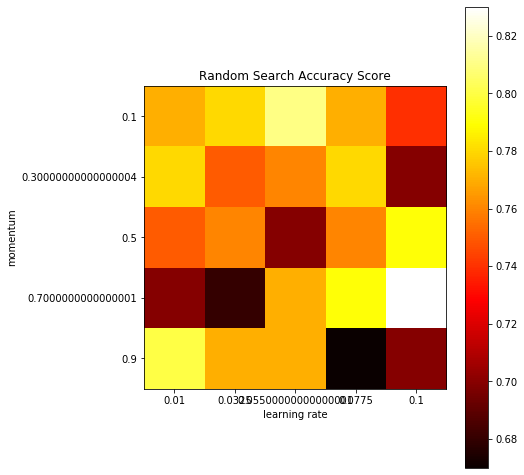

In [35]:
# Random Search Heat Map
prog_rs = prog_rs.reshape(len(lr_range),len(momentum_range))

plot_rs = plt.figure(figsize=(7, 8))
plt.subplots_adjust(left=.2, right=0.95, bottom=0.15, top=0.95)
plt.imshow(prog_rs, interpolation='nearest', cmap=plt.cm.hot)
plt.xlabel('learning rate')
plt.ylabel('momentum')
plt.colorbar()
plt.xticks(np.arange(len(lr_range)), lr_range)
plt.yticks(np.arange(len(momentum_range)), momentum_range)
plt.title('Random Search Accuracy Score')
plt.show()

## Best Parameters and Performances comparison 

### Configurations comparison

In [0]:
best_configurations = []
for alg in res_1:
  best_configurations.append(res_1[alg]['best_config'])
best_configurations = np.asarray(best_configurations)

In [37]:
best_configurations = pd.DataFrame([best_configurations[:,0], best_configurations[:,1]],
                                   columns=['HPO_EI', 'HPO_LCB', 'GS', 'RS'], 
                                   index=['Learning Rate', 'Momentum'])
best_configurations

,HPO_EI,HPO_LCB,GS,RS
Learning Rate,0.075518,0.022558,0.1,0.094328
Momentum,0.858786,0.481179,0.1,0.515128


### Performances comparison

In [38]:
# Classification Report EI
CR_EI = CR(HPO_EI)

              precision    recall  f1-score   support

         0.0       0.14      0.33      0.20        12
         1.0       0.89      0.73      0.80        88

    accuracy                           0.68       100
   macro avg       0.52      0.53      0.50       100
weighted avg       0.80      0.68      0.73       100



In [39]:
# Classification Report LCB
CR_LCB = CR(HPO_LCB)

              precision    recall  f1-score   support

         0.0       0.24      0.42      0.30        12
         1.0       0.91      0.82      0.86        88

    accuracy                           0.77       100
   macro avg       0.57      0.62      0.58       100
weighted avg       0.83      0.77      0.80       100



In [40]:
# Classification report Grid Search
config_GS = best_configurations.GS # GS best Configs
config_GS ={'learning_rate_init': config_GS[0],
            'momentum': config_GS[1]} 

CR_GS = CR(config_GS)

              precision    recall  f1-score   support

         0.0       0.16      0.33      0.22        12
         1.0       0.89      0.76      0.82        88

    accuracy                           0.71       100
   macro avg       0.53      0.55      0.52       100
weighted avg       0.81      0.71      0.75       100



In [41]:
# Classification report Random Search
config_RS = best_configurations.RS # RS best Configs
config_RS ={'learning_rate_init': config_RS[0],
            'momentum': config_RS[1]} 

CR_RS = CR(config_RS)

              precision    recall  f1-score   support

         0.0       0.16      0.33      0.22        12
         1.0       0.89      0.76      0.82        88

    accuracy                           0.71       100
   macro avg       0.53      0.55      0.52       100
weighted avg       0.81      0.71      0.75       100



### Best seen evolution

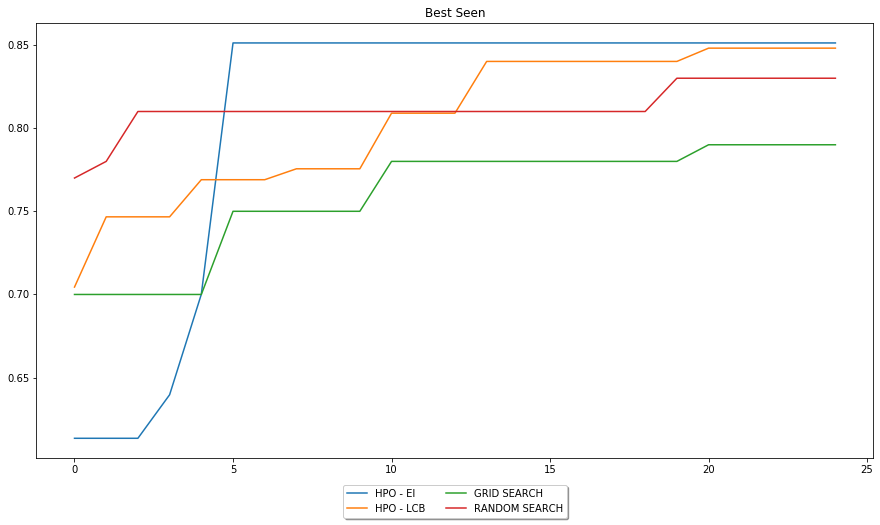

In [42]:
plot_bestseen(res_1, 25)

# STEP 2

In [0]:
# defining results dictionary that will be populated when experiments run
res_2 = {}

### Configuration Space and Scenario definition

In [0]:
# defining learning rate optimization range
learn_rate = UniformFloatHyperparameter("learning_rate_init", 
                                        lower=lr_lower, 
                                        upper=lr_upper)

In [0]:
# defining momentum rate optimization range
momentum = UniformFloatHyperparameter("momentum", 
                                      lower=momentum_lower, 
                                      upper=momentum_upper)

In [0]:
# defining first layer neurons optimization range
neurons_1_layer = UniformIntegerHyperparameter("neurons_1", 1,5)

In [0]:
# defining second layer neurons optimization range
neurons_2_layer = UniformIntegerHyperparameter("neurons_2", 1,5)

In [0]:
# Build Configuration Space which defines all parameters and their ranges
cs_step_2 = ConfigurationSpace()

In [49]:
cs_step_2.add_hyperparameters([learn_rate, momentum, neurons_1_layer, neurons_2_layer])

[learning_rate_init, Type: UniformFloat, Range: [0.01, 0.1], Default: 0.055,
 momentum, Type: UniformFloat, Range: [0.1, 0.9], Default: 0.5,
 neurons_1, Type: UniformInteger, Range: [1, 5], Default: 3,
 neurons_2, Type: UniformInteger, Range: [1, 5], Default: 3]

In [0]:
initial_runs_2 = 10
further_runs_2 = 100

In [0]:
initial_configs_2 = cs_step_2.sample_configuration(size = initial_runs_2)

In [52]:
scenario_step_2 = Scenario({"run_obj": "quality",
                     "runcount-limit":initial_runs_2 + further_runs_2,
                     "cs":cs_step_2,
                     "deterministic":"true"
                     })

INFO:smac.utils.io.cmd_reader.CMDReader:Output to smac3-output_2019-12-09_10:50:43_794495


## Hyperparameter Optimization

### Evaluation functions

In [0]:
# plot the evolution of "best seen" 
# Same as Step 1

In [0]:
#Make predictions and return the classification report

def CR_2(incumbent_cfg):
  smote = SMOTE(random_state=seed)
  mlp = MLPClassifier(hidden_layer_sizes=(incumbent_cfg['neurons_1'], 
                                          incumbent_cfg['neurons_2'],),
                      random_state=seed,
                      learning_rate_init=incumbent_cfg['learning_rate_init'],
                      momentum=incumbent_cfg['momentum'])
  
  model_pipeline = make_pipeline(smote, StandardScaler(), mlp)
  predictions = cross_val_predict(model_pipeline, x,y, cv =10)
  CR = classification_report(y, predictions)
  return print(CR)

### Smac Optimization functions

In [0]:
def nn_from_cfg_2(cfg):
  smote = SMOTE(random_state=seed)
  mlp = MLPClassifier(hidden_layer_sizes=(cfg['neurons_1'], 
                                          cfg['neurons_2'],),
                      random_state=seed,
                      learning_rate_init=cfg['learning_rate_init'],
                      momentum=cfg['momentum'])
  model_pipeline = make_pipeline(smote, StandardScaler(), mlp)
  scores = cross_val_score(model_pipeline, x, y, cv=10)
  return 1-np.mean(scores)  # Minimize!

In [0]:
# defining function that run and optimize smac
def run_smac_2(acquisition_function):
    smac = SMAC4HPO(scenario=scenario_step_2, 
                   rng=seed,
                   tae_runner=nn_from_cfg_2,
                   initial_design_kwargs={'configs': initial_configs_2},
                   acquisition_function=acquisition_function
                   )

    incumbent = smac.optimize()
    bestseen = 1-np.minimum.accumulate(list(
        smac.get_runhistory().cost_per_config.values()
        ))
    # put best configuration and bestseen in results dictionary
    res_2[f"HPO - {acquisition_function.__name__}"] = {
    'best_config': list(incumbent._values.values()),
    'bestseen': bestseen
    }
    return incumbent

### Experiment 2.1: Expect Input as acquisition function

In [57]:
HPO_EI_2 = run_smac_2(EI)

INFO:smac.facade.smac_hpo_facade.SMAC4HPO:Optimizing a deterministic scenario for quality without a tuner timeout - will make SMAC deterministic and only evaluate one configuration per iteration!
INFO:smac.initial_design.sobol_design.SobolDesign:Running initial design for 27 configurations
INFO:smac.facade.smac_hpo_facade.SMAC4HPO:<class 'smac.facade.smac_hpo_facade.SMAC4HPO'>
INFO:smac.intensification.intensification.Intensifier:Challenger (0.2265) is better than incumbent (0.2446) on 1 runs.
INFO:smac.intensification.intensification.Intensifier:Changes in incumbent:
INFO:smac.intensification.intensification.Intensifier:  learning_rate_init : 0.05951299705016369 -> 0.06694722422959863
INFO:smac.intensification.intensification.Intensifier:  momentum : 0.7217703915462074 -> 0.8729782457250568
INFO:smac.intensification.intensification.Intensifier:Challenger (0.1617) is better than incumbent (0.2265) on 1 runs.
INFO:smac.intensification.intensification.Intensifier:Changes in incumbent:
IN

### Experiment 2.2: Lower Confidence Bound as acquisition function

In [58]:
HPO_LCB_2 = run_smac_2(LCB)

INFO:smac.facade.smac_hpo_facade.SMAC4HPO:Optimizing a deterministic scenario for quality without a tuner timeout - will make SMAC deterministic and only evaluate one configuration per iteration!
INFO:smac.initial_design.sobol_design.SobolDesign:Running initial design for 27 configurations
INFO:smac.facade.smac_hpo_facade.SMAC4HPO:<class 'smac.facade.smac_hpo_facade.SMAC4HPO'>
INFO:smac.intensification.intensification.Intensifier:Challenger (0.1970) is better than incumbent (0.2272) on 1 runs.
INFO:smac.intensification.intensification.Intensifier:Changes in incumbent:
INFO:smac.intensification.intensification.Intensifier:  learning_rate_init : 0.05951299705016369 -> 0.06272670578037219
INFO:smac.intensification.intensification.Intensifier:  momentum : 0.7217703915462074 -> 0.23897364696749357
INFO:smac.intensification.intensification.Intensifier:  neurons_1 : 4 -> 1
INFO:smac.intensification.intensification.Intensifier:  neurons_2 : 5 -> 1
INFO:smac.intensification.intensification.Inte

## Best Parameters and Performances comparison 

### Configurations coparison

In [0]:
best_configurations_2 = []
for alg in res_2:
  best_configurations_2.append(res_2[alg]['best_config'])
best_configurations_2 = np.asarray(best_configurations_2)

In [60]:
best_configurations_2 = pd.DataFrame([best_configurations_2[:,0], best_configurations_2[:,1], best_configurations_2[:,2], best_configurations_2[:,3]],
                                   columns=['HPO_EI', 'HPO_LCB'], 
                                   index=['Learning Rate', 'Momentum', 'Neurons 1st layer', 'Neurons 2nd layer'])
best_configurations_2

,HPO_EI,HPO_LCB
Learning Rate,0.019787,0.089617
Momentum,0.824615,0.472846
Neurons 1st layer,2.000000,1.000000
Neurons 2nd layer,1.000000,1.000000


### Performances comparison

In [61]:
# Classification Report EI
CR_EI_2 = CR_2(HPO_EI_2)

              precision    recall  f1-score   support

         0.0       0.18      0.25      0.21        12
         1.0       0.89      0.84      0.87        88

    accuracy                           0.77       100
   macro avg       0.53      0.55      0.54       100
weighted avg       0.81      0.77      0.79       100



In [62]:
# Classification Report LCB
CR_LCB_2 = CR_2(HPO_LCB_2)

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)

  'precision', 'predicted', average, warn_for)



              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00        12
         1.0       0.88      1.00      0.94        88

    accuracy                           0.88       100
   macro avg       0.44      0.50      0.47       100
weighted avg       0.77      0.88      0.82       100



### Best seen evolution

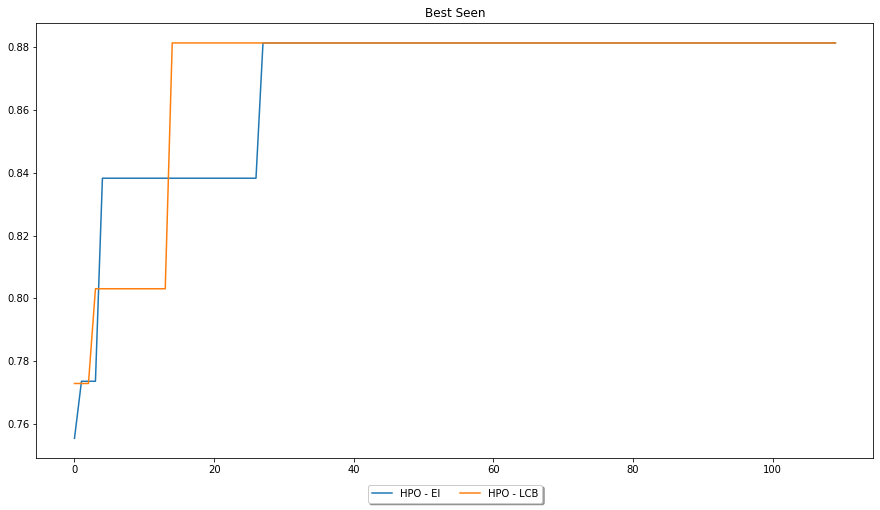

In [63]:
plot_bestseen(res_2, 110)